## 數據集來源：https://ade20k.csail.mit.edu/
## 檔案還蠻大，下載回來自己解壓 :D
http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar  850MB
http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar 86.2MB

#### 下面格子的這些東西要直接下載
#### https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
!chcp 65001
!echo 中文在我的電腦顯示會是亂碼耶  

zsh:1: command not found: chcp
中文在我的電腦顯示會是亂碼耶


### 下載windows的wget
https://eternallybored.org/misc/wget

放到 C:\Windows\System32

In [2]:
#!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
#!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
#!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
#!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
#!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
#### 需要安裝的coco資料集API
# %pip install pycocotools

In [3]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import glob, os, configparser, json
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
#root = '/Users/leonjye/Documents/MachineLearingData'
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'ChallengeData2017')

In [5]:
def Glob(x, extns=None):
    files = glob.glob(x + "/*") if "*" not in x else glob.glob(x)
    if extns:
        if isinstance(extns, str):
            extns = extns.split(",")
        files = [f for f in files if any([f.endswith(ext) for ext in extns])]
    return files

In [6]:
all_images = Glob(os.path.join(IMAGE_ROOT, 'images/training'))
all_annots = Glob(os.path.join(IMAGE_ROOT, 'annotations_instance/training'))

In [7]:
# 根據陣列的圖片個數來決定要幾個columns
def subplots(image_array):
    num_images = len(image_array)
    num_columns = 5
    num_rows = (num_images + num_columns - 1) // num_columns  # 向上取整
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
    axes = axes.flatten()  # 將二維陣列展平為一維陣列

    for i in range(num_images):
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # 隱藏坐標軸

    for j in range(i + 1, num_rows * num_columns):
        axes[j].axis('off')  # 隱藏多餘的子圖

    plt.tight_layout()
    plt.show()

In [8]:
# 根據陣列的圖片個數來決定要幾個columns
def subplots2(image_array):
    num_images = len(image_array)
    num_columns = 5
    num_rows = (num_images + num_columns - 1) // num_columns  # 向上取整
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
    axes = axes.flatten()  # 將二維陣列展平為一維陣列

    for i in range(num_images):
        # 將圖片轉換為RGB格式
        if(image_array[i].shape[0] == 3):
            image_array[i] = np.transpose(image_array[i], (1, 2, 0))
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # 隱藏坐標軸

    for j in range(i + 1, num_rows * num_columns):
        axes[j].axis('off')  # 隱藏多餘的子圖

    plt.tight_layout()
    plt.show()

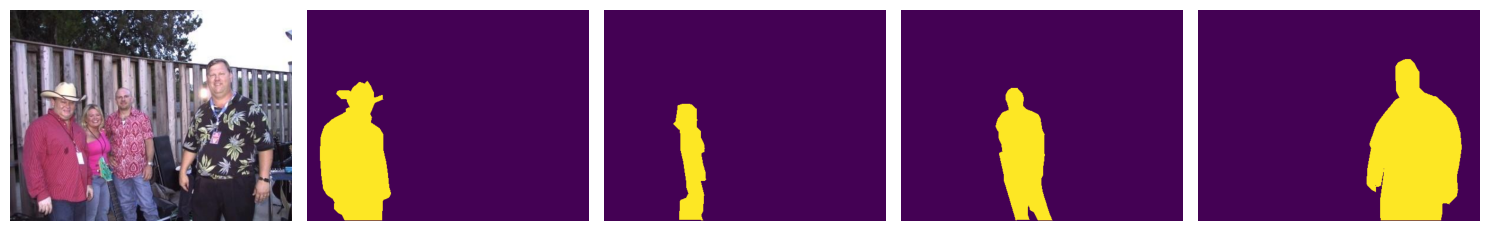

In [9]:
from PIL import Image
f = 'ADE_train_00014301'
im = Image.open(os.path.join(IMAGE_ROOT, 'images/training', f + '.jpg'))
im = im.convert('RGB')
im_array = np.array(im)
an = Image.open(os.path.join(IMAGE_ROOT, 'annotations_instance/training', f + '.png'))
an = an.convert('RGB')
an_array = np.array(an)
r,g,b = an_array[:,:,0], an_array[:,:,1], an_array[:,:,2]
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks])

In [10]:
import tqdm
def Tqdm(x, total=None, desc=None):
    total = len(x) if total is None else total
    return tqdm.tqdm(x, total=total, desc=desc)

In [11]:
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = Image.open(ann).convert('RGB')
    _ann = np.array(_ann).transpose(2, 0, 1)
    r,g,b = _ann[0], _ann[1], _ann[2]
    # 4 stands for person
    if 4 not in np.unique(r): continue
    annots.append(ann)
annots[:5]

100%|██████████| 5000/5000 [00:10<00:00, 456.89it/s]


['/Users/leonjye/Documents/MachineLearingData/ChallengeData2017/annotations_instance/training/ADE_train_00001087.png',
 '/Users/leonjye/Documents/MachineLearingData/ChallengeData2017/annotations_instance/training/ADE_train_00017183.png',
 '/Users/leonjye/Documents/MachineLearingData/ChallengeData2017/annotations_instance/training/ADE_train_00017197.png',
 '/Users/leonjye/Documents/MachineLearingData/ChallengeData2017/annotations_instance/training/ADE_train_00015780.png',
 '/Users/leonjye/Documents/MachineLearingData/ChallengeData2017/annotations_instance/training/ADE_train_00004855.png']

In [12]:
from sklearn.model_selection import train_test_split
#_annots = stems(annots)
# 只把檔名留下來，也要去掉副檔名 '/Users/leonjye/Documents/MachineLearingData/ChallengeData2017/annotations_instance/training/ADE_train_00007390.png' -> 'ADE_train_00007390'
_annots = [os.path.basename(ann).split(".")[0] for ann in annots]
trn_items, val_items = train_test_split(_annots, random_state=2)

In [13]:
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [14]:
from torch.utils.data import Dataset
import random
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = Image.open(path).convert('RGB')
        an = np.array(an)
        #print(f'an.shape: { an.shape}')
        # 這裡的an.shape是(H, W, C) 為什麼回轉的mask變成(C, H, W)了?
        an = an.transpose(2,0,1) #input shape is (H,W,C) but we need (C,H,W)
        r,g,b = an[0], an[1], an[2]
        #print(f'r.shape: {r.shape}')
        #print(f'r, g, b: {r}, {g}, {b}')
        #an = read(path, 1).transpose(2,0,1)
        #r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        #print(f'instances: {instances}')
        masks = np.zeros((len(instances), *r.shape))
        #print(f'masks.shape: {masks.shape}')
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        #print(f'masks: {masks}')
        return masks 

    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = os.path.join(IMAGE_ROOT, f'images/training/{_id}.jpg')
        #print(f'img_path: {img_path}')
        mask_path = os.path.join(IMAGE_ROOT, f'annotations_instance/training/{_id}.png')
        #print(f'mask_path: {mask_path}')
        #mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        #print(f'obj_ids: {obj_ids}')
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            #print(f'obj_pixels: {obj_pixels}')
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[random.randint(0, len(self))]

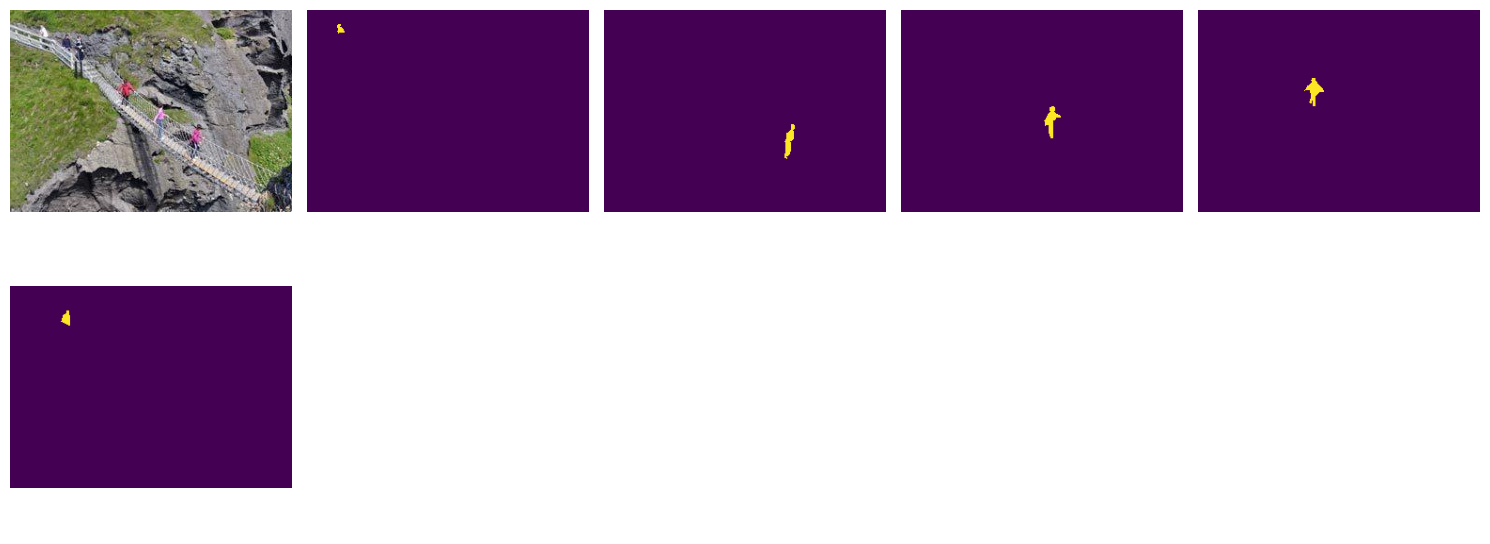

In [15]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
#inspect(im,targ)
subplots2([im, *targ['masks']])

In [16]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [17]:
model = get_model_instance_segmentation(2).to(device)
model

/Users/leonjye/Documents/PythonProjects/CompVision2025/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/leonjye/Documents/PythonProjects/CompVision2025/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [18]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [19]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [20]:
num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/Users/leonjye/Documents/PythonProjects/CompVision2025/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/184]  eta: 0:40:54  lr: 0.000032  loss: 2.9312 (2.9312)  loss_classifier: 0.9227 (0.9227)  loss_box_reg: 0.4502 (0.4502)  loss_mask: 1.5244 (1.5244)  loss_objectness: 0.0196 (0.0196)  loss_rpn_box_reg: 0.0142 (0.0142)  time: 13.3424  data: 0.0417
Epoch: [0]  [ 10/184]  eta: 0:36:34  lr: 0.000305  loss: 2.3409 (2.2506)  loss_classifier: 0.6585 (0.6475)  loss_box_reg: 0.3734 (0.3651)  loss_mask: 1.2566 (1.1872)  loss_objectness: 0.0304 (0.0341)  loss_rpn_box_reg: 0.0142 (0.0166)  time: 12.6125  data: 0.0503
Epoch: [0]  [ 20/184]  eta: 0:33:26  lr: 0.000578  loss: 1.3474 (1.6939)  loss_classifier: 0.2929 (0.4449)  loss_box_reg: 0.3381 (0.3226)  loss_mask: 0.7365 (0.8673)  loss_objectness: 0.0329 (0.0345)  loss_rpn_box_reg: 0.0125 (0.0244)  time: 12.1786  data: 0.0507
Epoch: [0]  [ 30/184]  eta: 0:31:39  lr: 0.000851  loss: 1.1464 (1.4995)  loss_classifier: 0.2561 (0.3926)  loss_box_reg: 0.3009 (0.3309)  loss_mask: 0.4350 (0.7172)  loss_objectness: 0.0321 (0.0333)  loss_rp

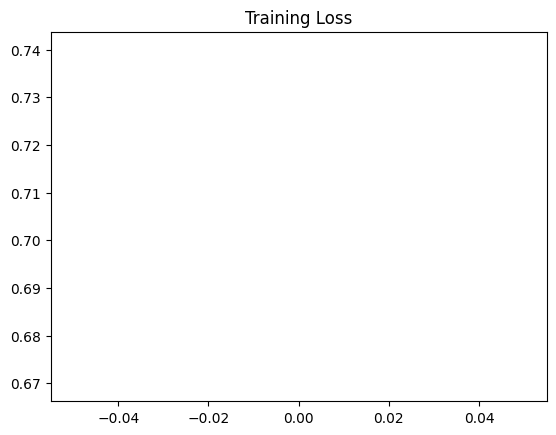

In [21]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

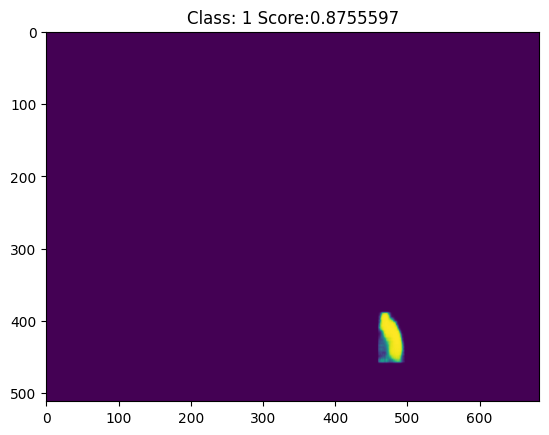

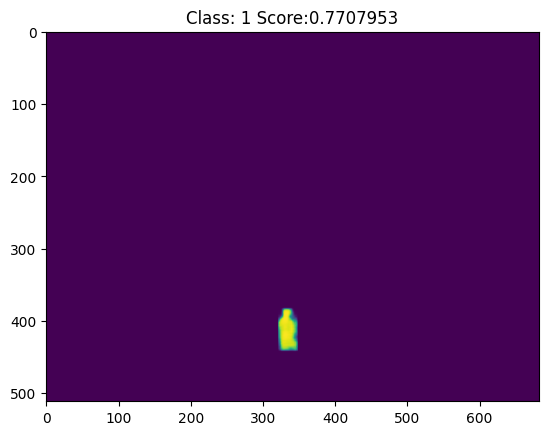

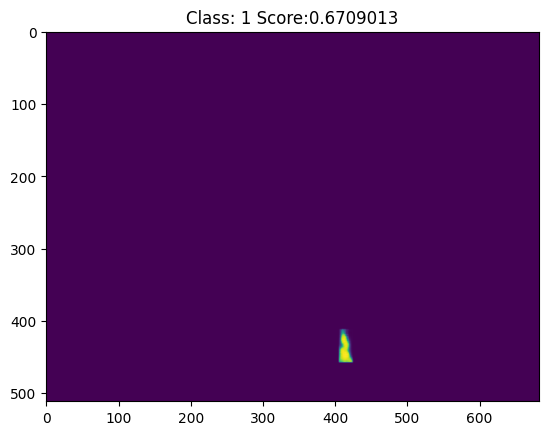

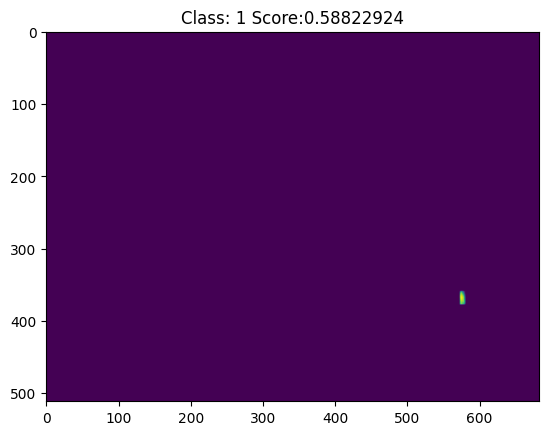

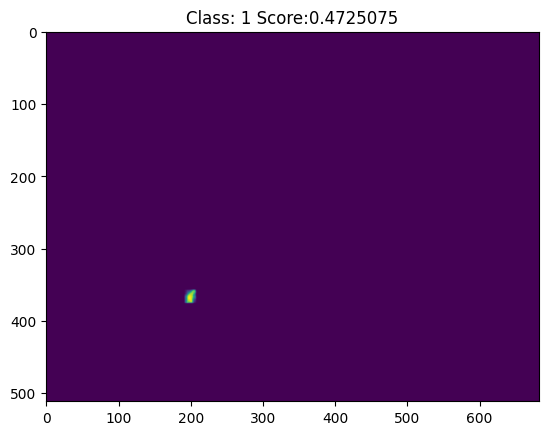

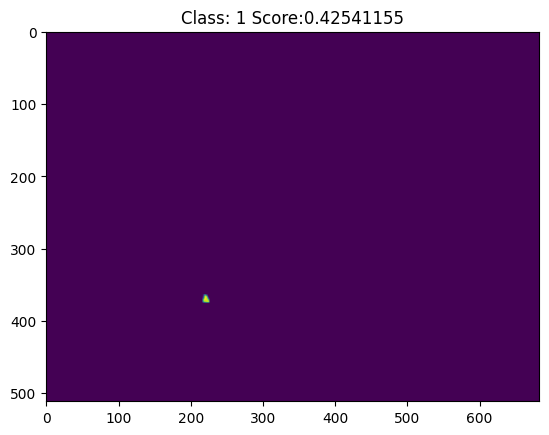

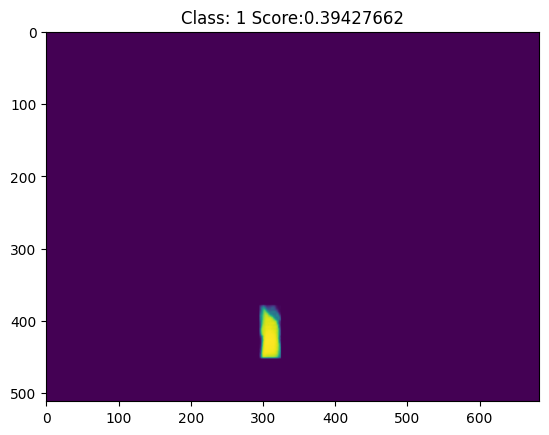

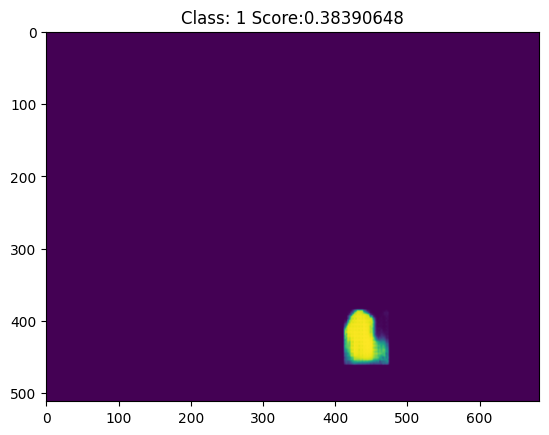

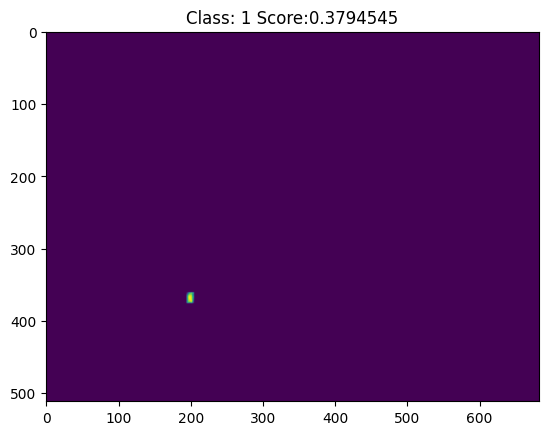

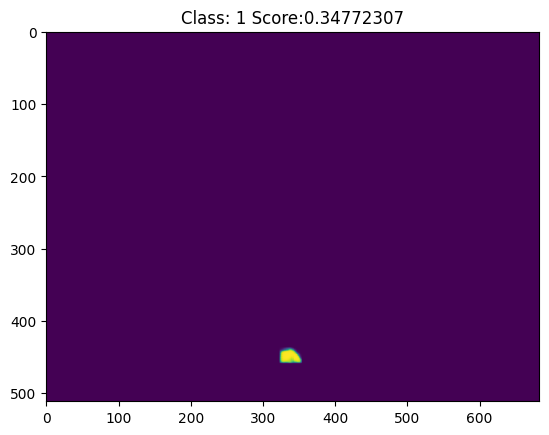

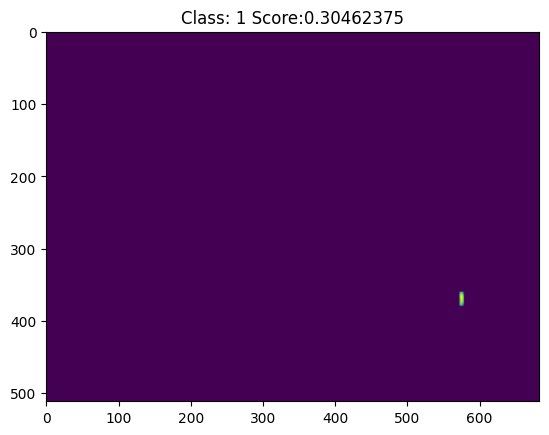

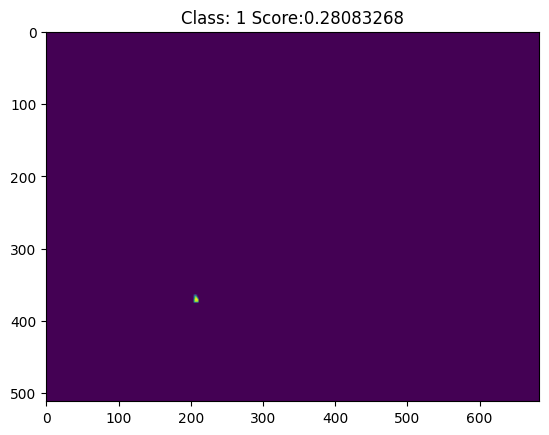

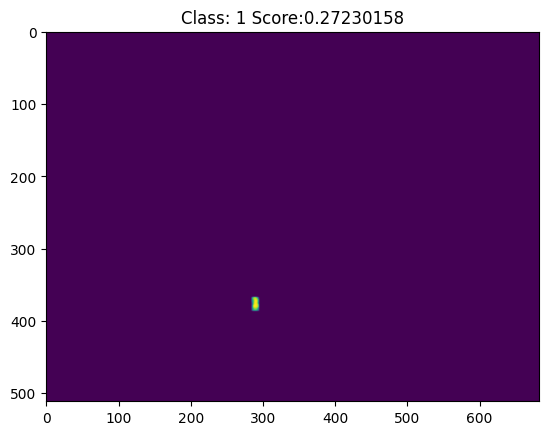

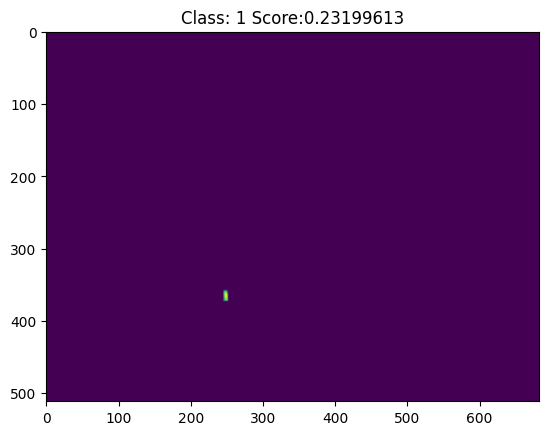

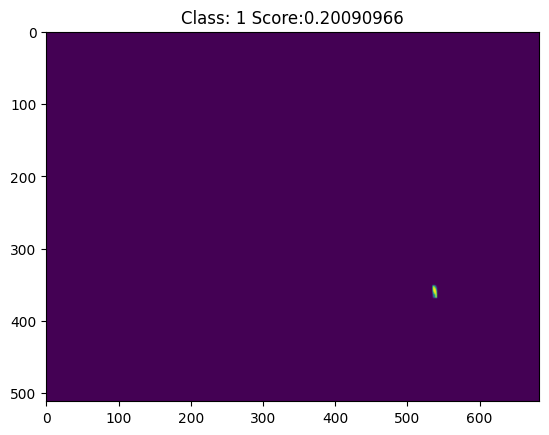

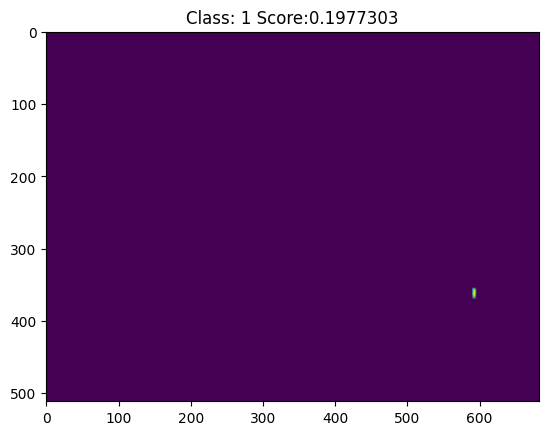

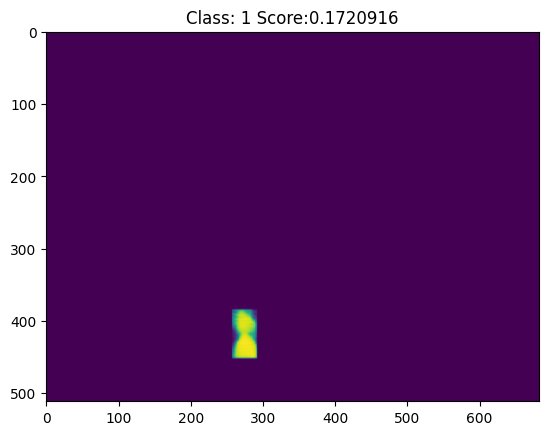

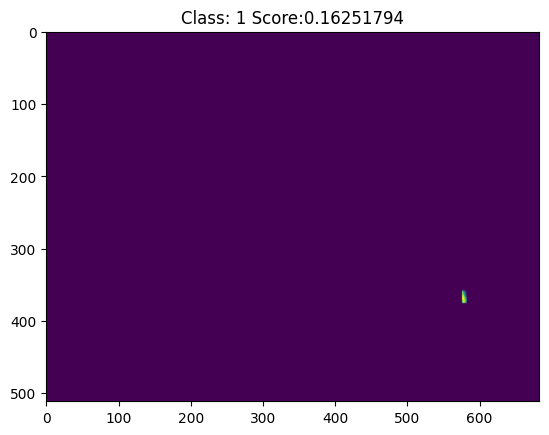

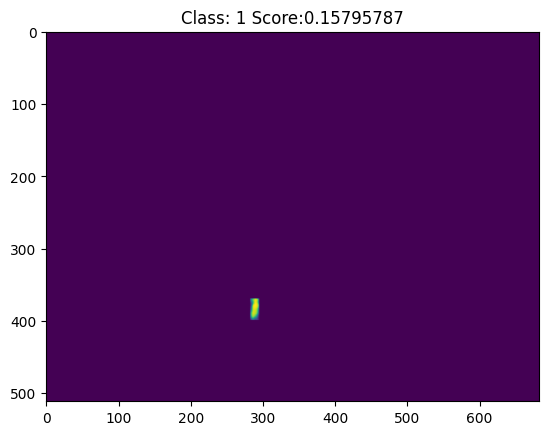

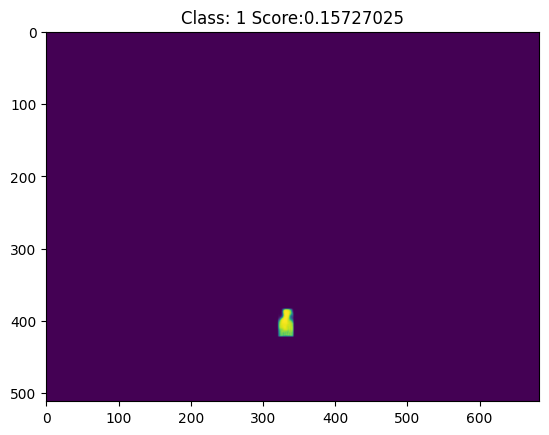

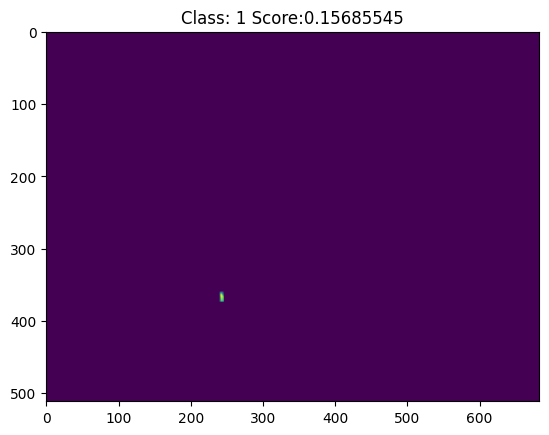

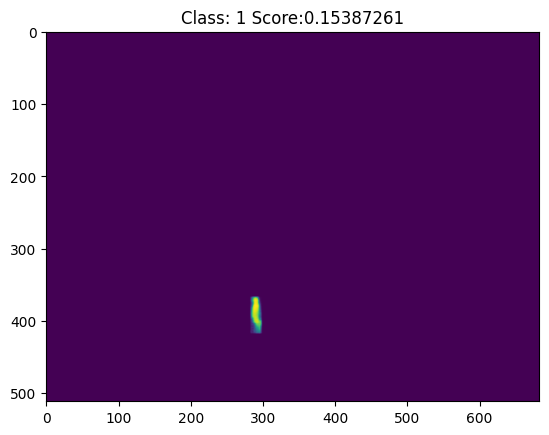

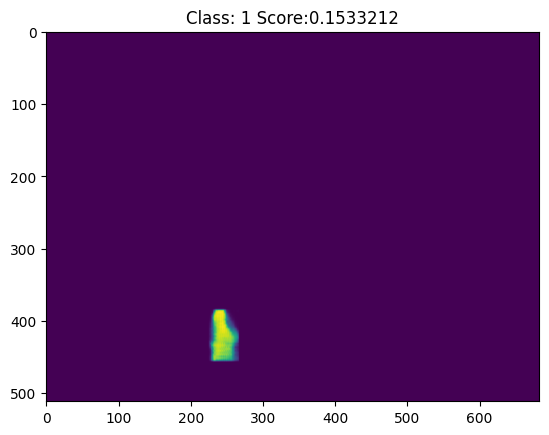

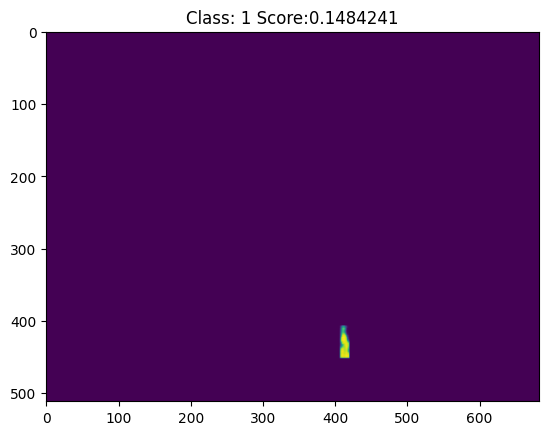

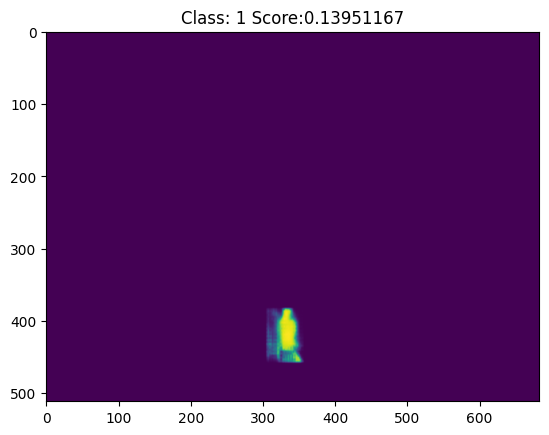

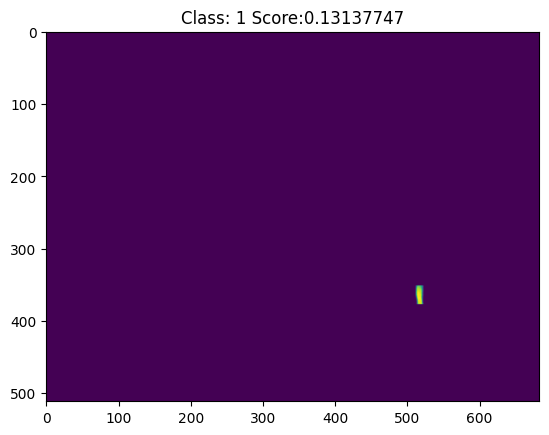

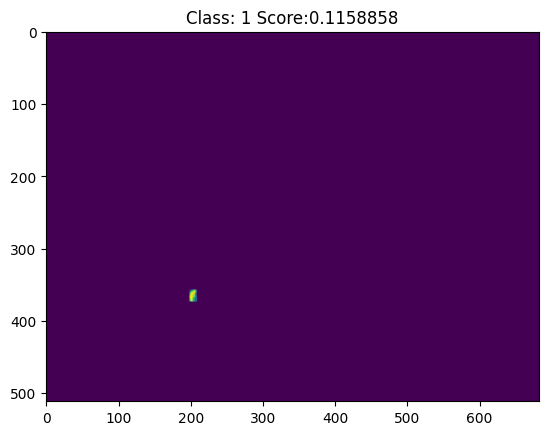

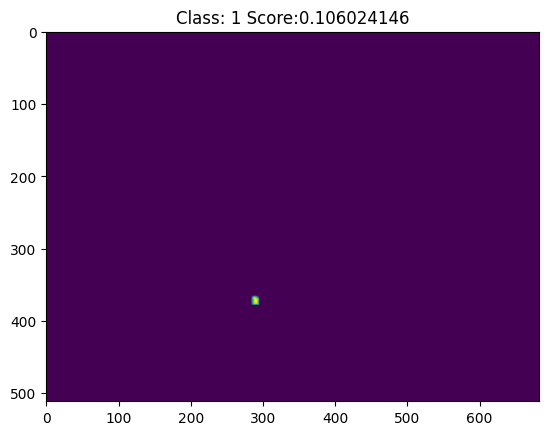

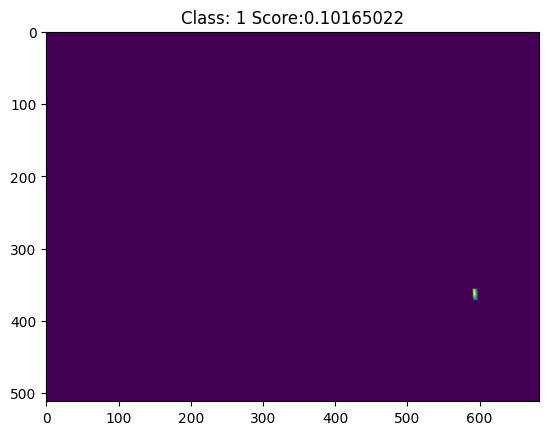

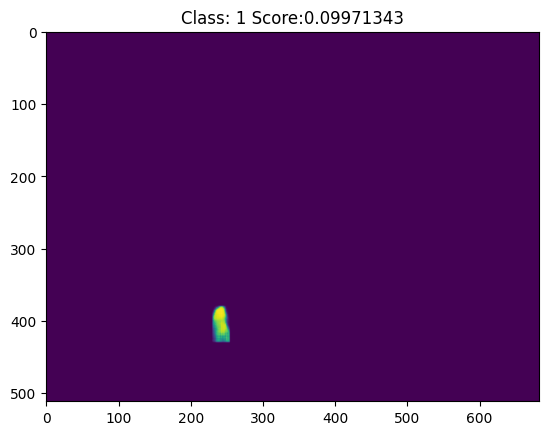

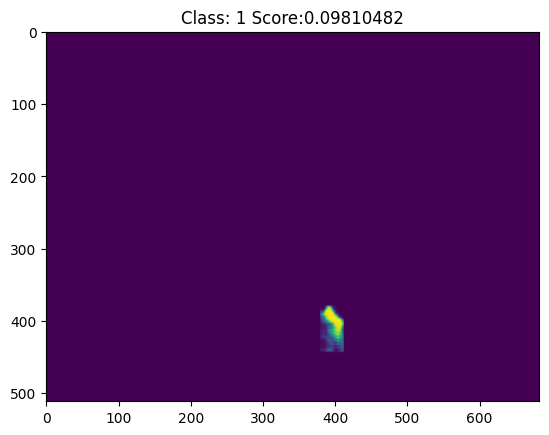

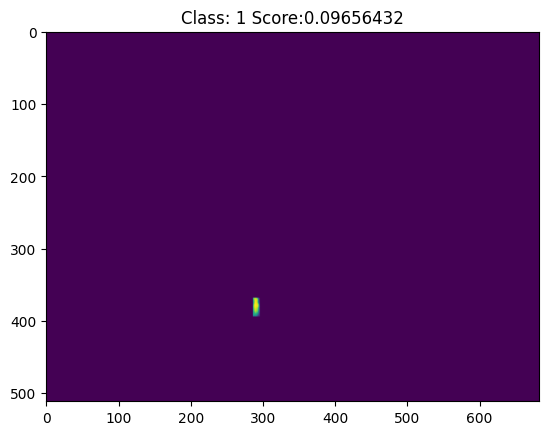

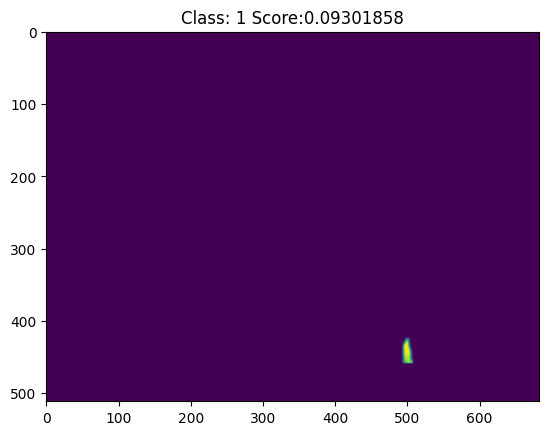

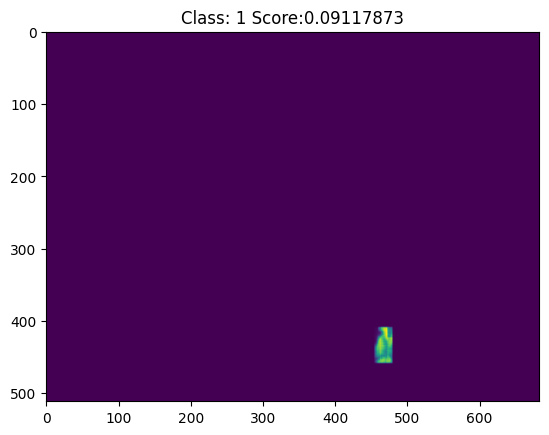

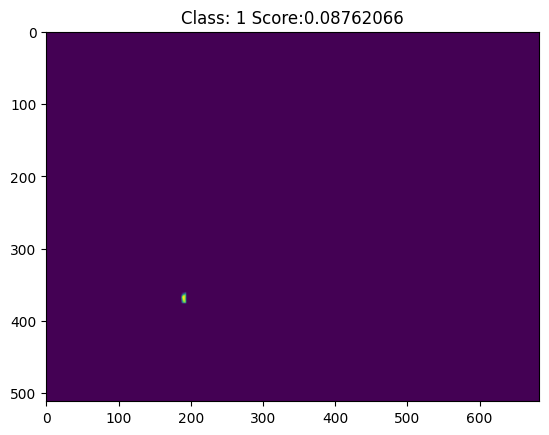

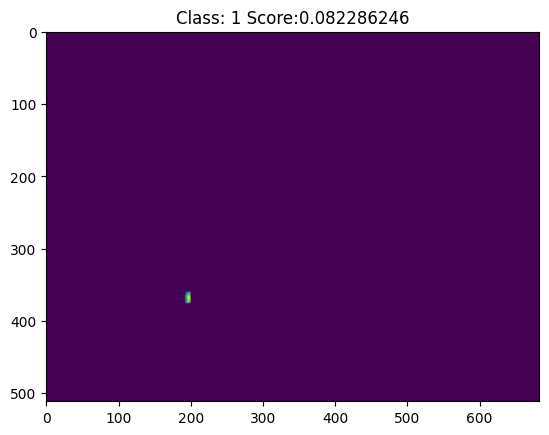

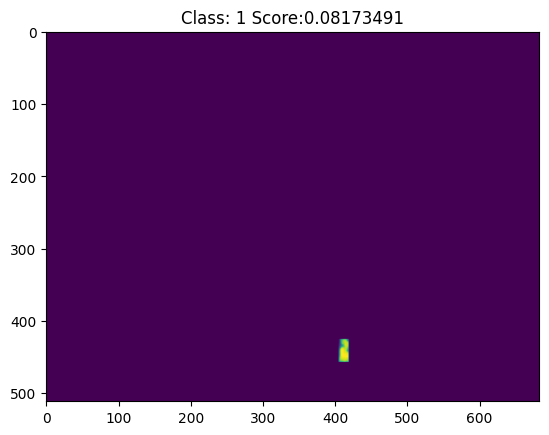

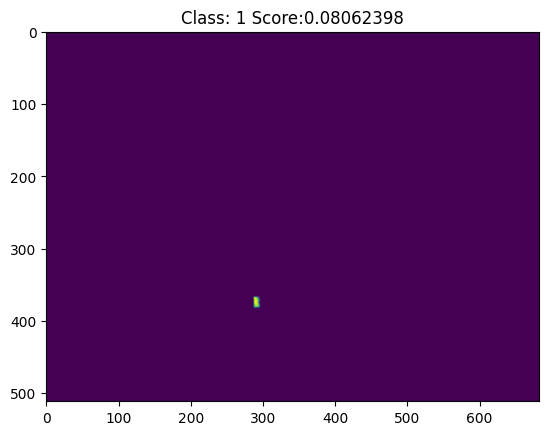

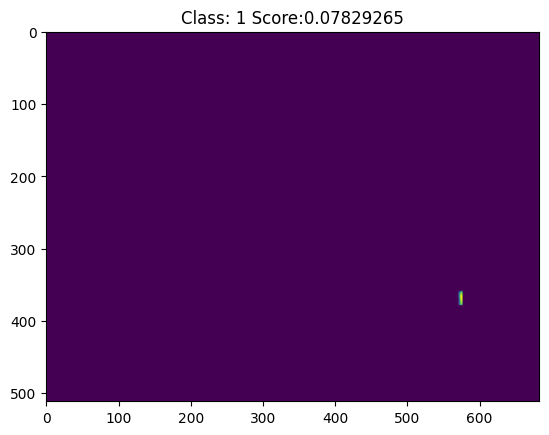

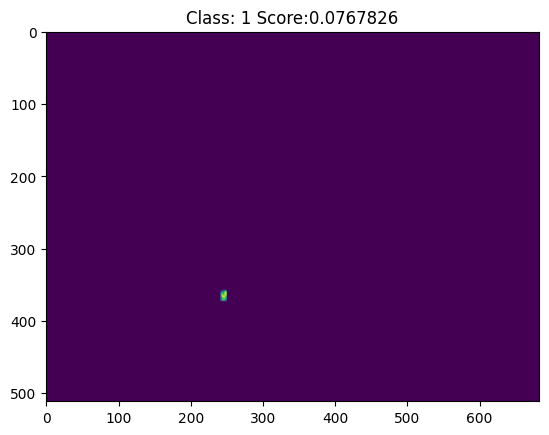

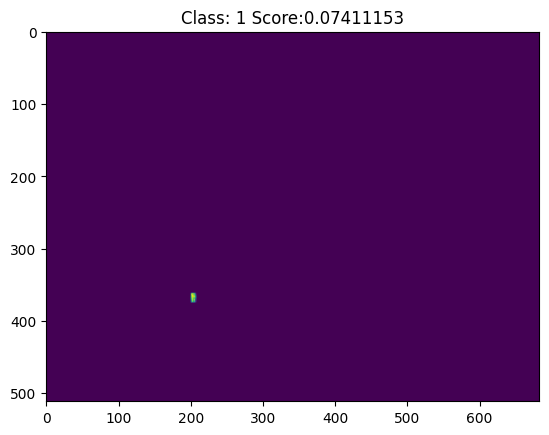

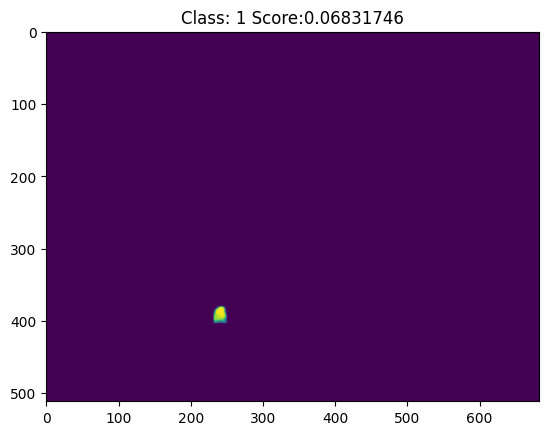

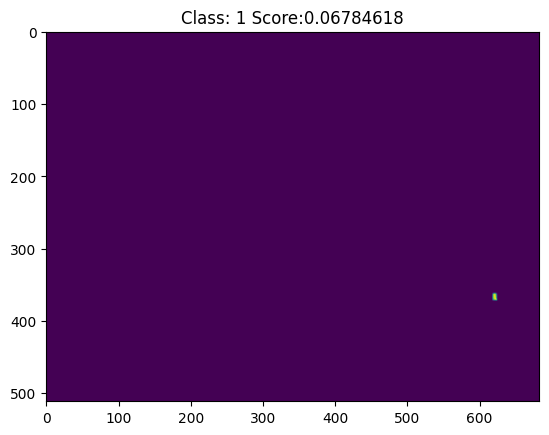

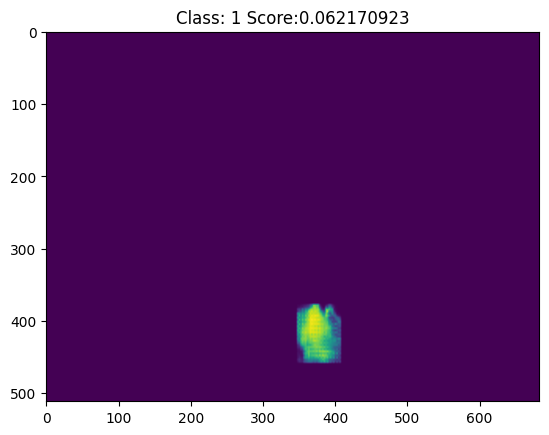

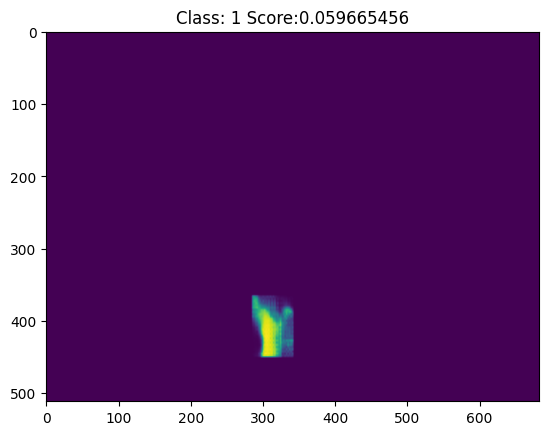

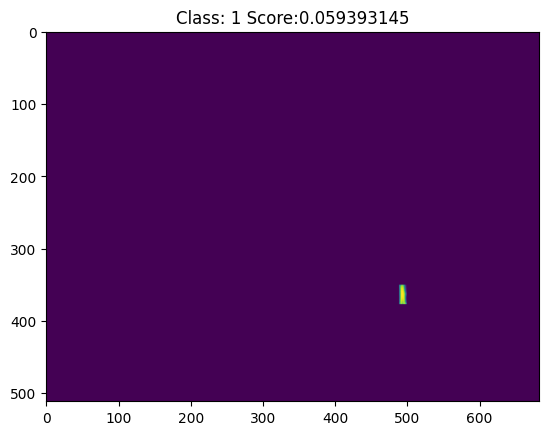

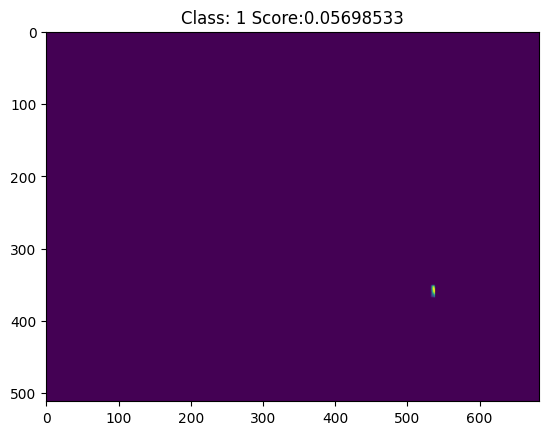

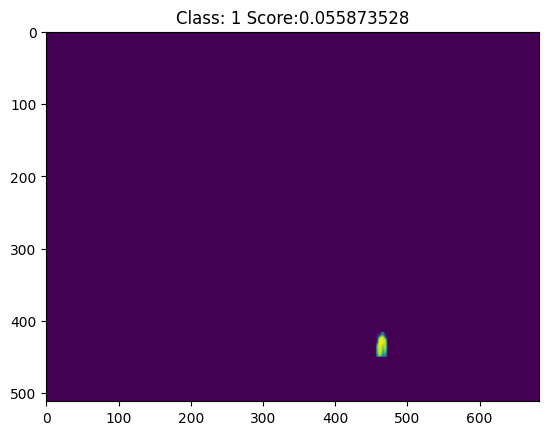

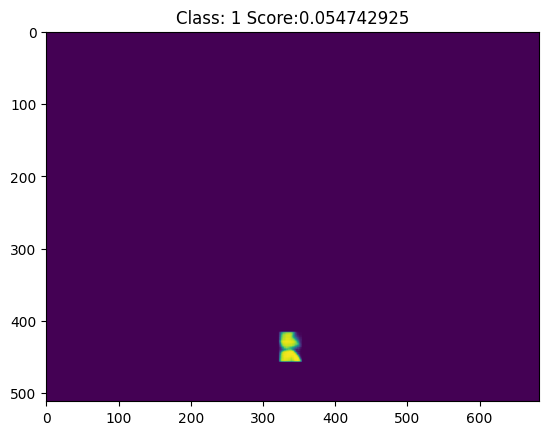

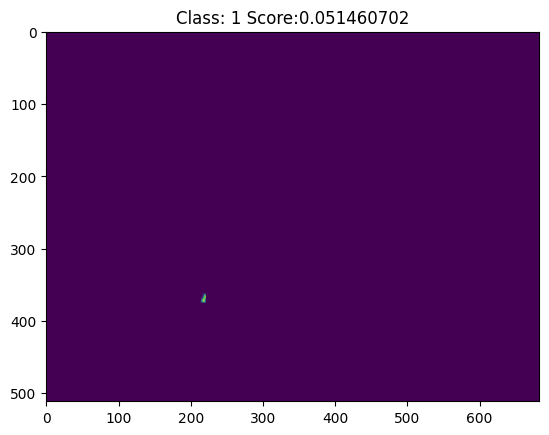

In [30]:
model.eval()
im = dataset_test[10][0]
im = im.permute(1,2,0)
plt.imshow(im)
im = dataset_test[10][0].unsqueeze(0)
im = im.to(device)
with torch.no_grad():
    prediction = model(im)
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()